# Climbing Rocks:
## Attempting to combine data analytics and climbing
***
### by Sam Silber



**What traits, if any, are most important in determining the highest level a rock climber is able to perform at?**

**Are physical traits (height, weight, etc.) limiting factors to this?**

**Conversely, are simple measures of experience most important?**

I will be answering these questions and more using data from the climbing logbook website 8a.nu.

All credit to David Cohen for scrapping this data and posting it to Kaggle:
https://www.kaggle.com/dcohen21/8anu-climbing-logbook

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
%matplotlib inline

# Read-in and Merges

We want to merge information from the user, method, and grade tables onto the ascent table (which will act as our "main" dataset). 

If you want to follow along you'll have to download the sqlite database from the link above-- it was apparently too big to be hosted on GitHub. If anyone knows a better solution to this please let me know!!

In [101]:
# Connect with sqlite database
con = sqlite3.connect("database.sqlite")

### Method Table

This table contains information on the different classifications of how a route was climbed. In the ascents dataset, each climb has an ID as to the method, so this table is just useful for being able to attach a climbing method to an ID. 8a.nu has 4 climbing method classifications (in order of most desireable):
    
   A. Onsight: Complete a route on your first try without "beta" ((climbing terminology for knowing something about a route. This could be anything from watching someone else climb it to reading up about the route's topography). This is considered the cleanest, highest level, and most desireable method of completing a route. 
    
    
   B. Flash: Complete a route on your first try, but with "beta". The distinction between flashing and onsighting a route may seem arbitrary to non-climbers, but is an import distinction in the climbing community. 
    
    
   C.  Redpoint: Complete a route having previously attempted it.
    
    
   D. Toprope: All 3 above methods imply that the climb has been "lead", or the climber is bringing rope up with them as they climb and clipping into pieces of protection that they place. Toproping is when the rope is already set up above the climber, and is considered a less "pure" form of climbing as it makes the climb physically and mentally easier (e.g., falling leaves one suspended in the air, whereas in lead climbing one would fall past they last piece of protection that placed).
    
 

In [102]:
### Prepare method table for merge with ascents
method = pd.read_sql_query("SELECT * from Method", con)

# Drop variables irrelevant to our analysis; rename for merge
method.drop(["shorthand", "score"], axis=1, inplace=True)
method.rename(columns={"id" : "method_id", "name" : "method_name"}, inplace=True)

method

,method_id,method_name
0,1,Redpoint
1,2,Flash
2,3,Onsight
3,4,Toprope
4,5,Onsight


Looks like both 3 and 5 indicate onsight climbs. These will be consolidated later.

### User Table

This table has the information associated with each individual climber, including name, sex, height, weight, country of origin, etc. 

There are many users with a variety of inconsistencies because all of the data is manually input. We will have to clean and flag a variety of users to ensure we are using valid and representative climbers.

In [142]:
user = pd.read_sql_query("SELECT * from User", con, parse_dates="birth")
user.head()

,id,first_name,last_name,city,country,sex,height,weight,started,competitions,...,sponsor2,sponsor3,best_area,worst_area,guide_area,interests,birth,presentation,deactivated,anonymous
0,1,Leif,Jägerbrand,Göteborg,SWE,0,177,73,1996,,...,,,"Railay beach, Krabi, Thailand",None,,,1976-03-10,,0,0
1,2,Andreas,Collisch,stockholm,SWE,0,0,0,2000,,...,,,,,,,NaT,,0,0
2,3,Magnus,Öberg,Umeå,SWE,0,180,78,1995,,...,,,Hell,Umeå,,,1973-09-09,,0,0
3,4,Annika,Frodi-Lundgren (f),Goteborg,SWE,1,165,58,2001,,...,,,,None,,,1984-07-26,,0,0
4,5,Joe,McLoughlin,North Attleboro,USA,0,0,0,1991,,...,,,,None,,,1969-05-07,,0,0


There looks to be a good amount of extraneous information, so let's just keep information related to a climber's physical attributes (sex, height, weight), as well as information on their birthday and when they started climbing.

In [143]:
user.drop(["city", "competitions", "occupation", "best_area", "worst_area", "guide_area", "interests", "presentation", "deactivated", "anonymous", "sponsor2", "sponsor3", "sponsor1", "country"], axis=1, inplace=True)
user.rename(columns={"id" : "user_id", "country" : "climber_country"}, inplace=True)

user.head()

,user_id,first_name,last_name,sex,height,weight,started,birth
0,1,Leif,Jägerbrand,0,177,73,1996,1976-03-10
1,2,Andreas,Collisch,0,0,0,2000,NaT
2,3,Magnus,Öberg,0,180,78,1995,1973-09-09
3,4,Annika,Frodi-Lundgren (f),1,165,58,2001,1984-07-26
4,5,Joe,McLoughlin,0,0,0,1991,1969-05-07


Check for nulls:


In [144]:
user.isnull().sum()

user_id           0
first_name        0
last_name         0
sex               0
height            0
weight            0
started           0
birth         34738
dtype: int64

Birthday will be import to our analysis later, so we need to flag those without birthdays, and create a list of users and their birthdays to merge back on later (since null values will get dropped in a groupby)

In [145]:
user["miss_bd"]=np.where(user.birth.isnull(), 1, 0)
birthdays = user[["user_id", "birth"]]

We can also see in the above dataframe that there are climbers who also have 0s in their height and weight fields. Like birthday, climbers may not have wanted to share this online. Let's flag these as well.

In [146]:
user["weight_invalid"]=np.where((user.weight==0), 1, 0)
user["height_invalid"]=np.where((user.height==0), 1, 0)

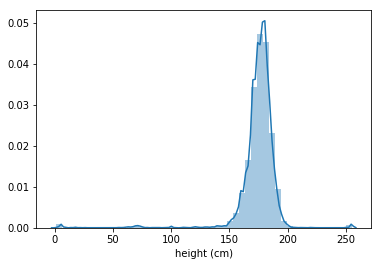

In [147]:
#Plot height distribution
sns.distplot(user.height[user.height_invalid==0])
plt.xlabel(s="height (cm)")

Looks like there's still some weirdly low/high heights (it's a European site, so this is in centimeters). Based on the above histogram, let's make our boundaries 150cm to 200cm (sorry anomalous climbers who are actually in that height range!)

In [148]:
user["height_invalid"]=np.where((user.height < 150) | (user.height > 200),1,0)

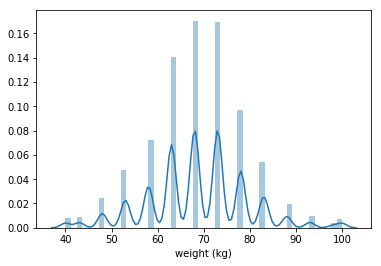

In [149]:
# Plot weight distribution
sns.distplot(user.weight[user.weight_invalid==0])
plt.xlabel(s="weight (kg)")

The weight field on 8a.nu is selected instead of typed in, hence the nice bucketing and reasonable range. There's still room for anomalous height/weight combinations, though, so let's calculate each user's Body Mass Index (BMI):

        BMI = weight(kg) / height(cm)^2


In [150]:
user['BMI'] = (user.weight) / ((user.height)/100)**2
user['BMI_invalid'] = np.where((user.height_invalid ==1 ) | (user.weight_invalid == 1),1,0)

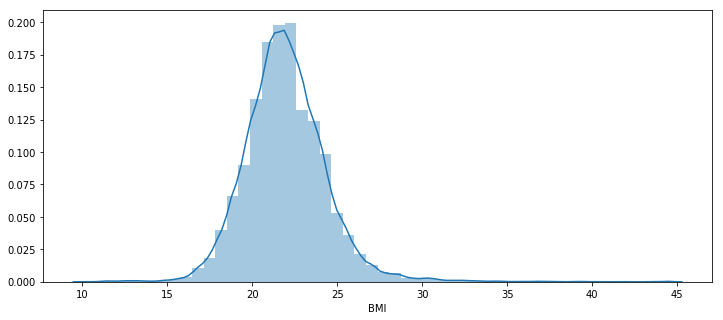

In [154]:
# Plot BMI distribution
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
sns.distplot(user.BMI[user.BMI_invalid==0])


There still appears to be some outliers. The $Internet^{(tm)}$ tells me that a BMI below 18.5 is considered underweight, and a BMI over 30 is considered obsese. 

Link to source: https://www.nhs.uk/chq/Pages/3215.aspx?CategoryID=52

Knowing that and looking at the above histogram, let's make our range a BMI of 16 to 31:

In [113]:
user["BMI_invalid"]=np.where((user.BMI < 16) | (user.BMI > 31),1,0)

Consolidate height/weight/BMI invalid flags for future analysis:

In [114]:
user["physicals_invalid"]=np.where((user.height_invalid==1) | (user.weight_invalid==1) | (user.BMI_invalid==1),1,0)
user.drop(["height_invalid", "weight_invalid", "BMI_invalid"], axis=1).head()

,user_id,first_name,last_name,sex,height,weight,started,birth,miss_bd,BMI,physicals_invalid
0,1,Leif,Jägerbrand,0,177,73,1996,1976-03-10,0,23.301095,0
1,2,Andreas,Collisch,0,0,0,2000,NaT,1,NaN,1
2,3,Magnus,Öberg,0,180,78,1995,1973-09-09,0,24.074074,0
3,4,Annika,Frodi-Lundgren (f),1,165,58,2001,1984-07-26,0,21.303949,0
4,5,Joe,McLoughlin,0,0,0,1991,1969-05-07,0,NaN,1


In [115]:
# Total number of climbers in the user table
len(user)

62593

### Grade Table

This table associates an ID in each ascent observation with that ascent's grade. As described earlier, a grade for a climb is essentially how difficult it is, and I'm hoping to predict the maximum grade one is able to climb. 

We'll be using the European grading system (which is much more granular), though I've kept the U.S. Yosemite system for my own reference.



In [116]:
### Prepare grade table for merge with ascents
grade = pd.read_sql_query("SELECT * from Grade", con)

# Keep grade classifiers; rename for merge
grade = grade.filter(["id", "fra_routes", "usa_routes"])
grade.rename(columns={"id" : "grade_id"}, inplace=True)

In [117]:
grade.head(len(grade))

,grade_id,fra_routes,usa_routes
0,1,-,3/4
1,2,1,
2,3,1a,
3,4,1b,
4,5,1c,
5,6,1+,
6,7,2,5.1
7,8,2a,
8,9,2b,
9,10,2c,


### Ascent Table

This data contains one observation per recorded ascent. 

In [118]:
### Prepare ascent table
ascent = pd.read_sql_query("SELECT * from Ascent", con, parse_dates=["date", "rec_date", "project_ascent_date"])

# Drop variables irrelevant to our analysis
ascent.drop(["raw_notes", "year", "notes", "last_year", "rec_date", "rating", "repeat", "project_ascent_date", "description", "yellow_id", "user_recommended", "chipped", "comment", "name", "crag_id", "crag", "sector_id", "sector", "country", "total_score", "exclude_from_ranking"], axis=1, inplace=True)

In [119]:
ascent.head(5)

,id,user_id,grade_id,method_id,climb_type,date,climb_try
0,2,1,36,3,0,1999-02-06 23:00:00,0
1,3,1,36,3,0,1999-04-30 22:00:00,0
2,4,1,36,3,0,1999-07-26 22:00:00,0
3,5,1,36,3,0,1999-07-26 22:00:00,0
4,6,1,36,3,0,1999-07-31 22:00:00,0


Drop if a climb was tried but not completed (climb_try==1):

In [120]:
ascent = ascent[ascent.climb_try!=1]
ascent.drop("climb_try", axis=1, inplace=True)

Merge all of the above datasets together. Now we can associate a climber with each climb, as well as the method and grade associated with method_id and grade_id.

In [121]:
ascent = pd.merge(ascent, method, on="method_id")
ascent = pd.merge(ascent, user, on="user_id")
ascent = pd.merge(ascent, grade, on="grade_id")

In [122]:
# Make all onsight climbs method_id==3
ascent.method_id.replace(to_replace=5, value=3, inplace=True)

# Feature Engineering

Let's get some counts of the total number of climbs each climber has completed, as well as counts for each of the above described methods of climbing. We also want to get the first and last year each climber logged a climb. This will be talked about next:

In [123]:
# Create counters to get total number of climbs
ascent['counter'] = 1

# Create dummies for each climbing method for counts
method_dummies = pd.get_dummies(ascent.method_id, prefix="method", prefix_sep="_")
ascent = ascent.merge(method_dummies, left_index=True, right_index=True)

# Pull year from ascent date for first year and most recent year
ascent['year'] = ascent.date.dt.year

#Group ascent by person to get their maximum grade (our y of interest) and total number of climbs
by_person = ascent.groupby(["user_id", "height", "weight", "sex", "BMI","started", "miss_bd", "physicals_invalid"], as_index=False).agg({'grade_id' : ['max', "mean"], 'year' : ['max', 'min'], 'climb_type' : 'sum', 'counter' : 'sum', 'method_1' : 'sum', 'method_2' : 'sum', 'method_3' : 'sum', 'method_4' : 'sum'})

#Rename multindex columns
by_person.columns = ['_'.join(var).strip() for var in by_person.columns.values]
by_person.reset_index(inplace=True)
by_person.columns = by_person.columns.str.replace(r'_$', '')


In [124]:
# Get the first year that each climber climbed their maximum grade
max_grade = by_person[["user_id", "grade_id_max"]]
ascent = pd.merge(ascent, max_grade, on="user_id")
ascent = ascent[ascent.grade_id == ascent.grade_id_max]
ascent = ascent[["user_id", "year"]].sort_values(["user_id", "year"])
max_grade = ascent.groupby("user_id", as_index=False).min()
max_grade.rename(columns={"year" : "year_max_grade"}, inplace=True)

by_person = pd.merge(by_person, max_grade, on="user_id")

In [125]:
# Make ascent blank because it makes my computer slow :(
ascent=""

In [126]:
# Create percentage of each climb method, as well as climb type
by_person["redpoint_pct"] = by_person.method_1_sum / by_person.counter_sum
by_person["flash_pct"] = by_person.method_2_sum / by_person.counter_sum
by_person["onsite_pct"] = by_person.method_3_sum / by_person.counter_sum
by_person["toprope_pct"] = by_person.method_4_sum / by_person.counter_sum
by_person["route_pct"] = by_person.climb_type_sum / by_person.counter_sum

by_person.drop(["method_1_sum", "method_2_sum", "method_3_sum", "method_4_sum", "climb_type_sum"], axis=1, inplace=True)
by_person.head()   

,index,user_id,height,weight,sex,BMI,started,miss_bd,physicals_invalid,year_max,year_min,counter_sum,grade_id_max,grade_id_mean,year_max_grade,redpoint_pct,flash_pct,onsite_pct,toprope_pct,route_pct
0,0,1,177,73,0,23.301095,1996,0,0,2005,1998,210,62,44.433333,2001,0.728571,0.009524,0.257143,0.004762,0.290476
1,1,3,180,78,0,24.074074,1995,0,0,2001,1995,61,62,51.819672,1999,0.950820,0.049180,0.000000,0.000000,0.196721
2,2,4,165,58,1,21.303949,2001,0,0,2009,2003,180,64,53.038889,2008,0.527778,0.127778,0.338889,0.005556,0.050000
3,3,6,185,73,0,21.329438,1992,0,0,2001,1999,31,64,58.193548,2001,0.935484,0.064516,0.000000,0.000000,1.000000
4,4,10,167,63,0,22.589551,1992,0,0,2017,1991,727,64,48.215956,2000,0.599725,0.020633,0.302613,0.077029,0.114168


In [127]:
# Merge birthday back on. This will drop some users as not every user has logged an ascent.
by_person = pd.merge(by_person, birthdays, on="user_id")

In [128]:
# Check for the total number of climbers
len(by_person)

24653

We can created a feature that shows the number of years of experience a climber has by subtracting the year of the "started" variable (from Users, tells us what year each climber started climbing) from the year of their most recent climb.

Like many other of the variables, the "started" variables has some 0/weird values. For those, we'll replace their "started" value with the year of their first logged climb.

In [129]:
# Get birth year
by_person["birth_year"] = by_person[by_person.miss_bd==0].birth.dt.year

# # Replace 0s, started years that are before birthdays, and started years that haven't happened yet with the year of their first climb
by_person.loc[by_person.started==0, "started"] = by_person.year_min
by_person.loc[by_person.birth_year >= by_person.started, "started"] = by_person.year_min
by_person.loc[by_person.started > 2017, "started"] = by_person.year_min

# # Create years climbing variable
by_person["years_climbing"] = by_person.year_max - by_person.started

# # Drops
by_person.drop(["year_min", "year_max", "index", "birth", "birth_year"], axis=1, inplace=True)

# # Set index
by_person.set_index("user_id", inplace=True)



Now we can also create a variable to see how long it took each person to climb their highest grade:

In [130]:
by_person["years_to_max"] = by_person.year_max_grade - by_person.started
by_person.loc[by_person.years_to_max < 0, "years_to_max"] = 0

In [131]:
# # Show final data 
by_person.head()

,height,weight,sex,BMI,started,miss_bd,physicals_invalid,counter_sum,grade_id_max,grade_id_mean,year_max_grade,redpoint_pct,flash_pct,onsite_pct,toprope_pct,route_pct,years_climbing,years_to_max
user_id,,,,,,,,,,,,,,,,,,
1,177,73,0,23.301095,1996,0,0,210,62,44.433333,2001,0.728571,0.009524,0.257143,0.004762,0.290476,9,5
3,180,78,0,24.074074,1995,0,0,61,62,51.819672,1999,0.950820,0.049180,0.000000,0.000000,0.196721,6,4
4,165,58,1,21.303949,2001,0,0,180,64,53.038889,2008,0.527778,0.127778,0.338889,0.005556,0.050000,8,7
6,185,73,0,21.329438,1992,0,0,31,64,58.193548,2001,0.935484,0.064516,0.000000,0.000000,1.000000,9,9
10,167,63,0,22.589551,1992,0,0,727,64,48.215956,2000,0.599725,0.020633,0.302613,0.077029,0.114168,25,8


# Analysis and Model Selection

Let's look at the distribution of maximum climbing grade by person (our y of interest):

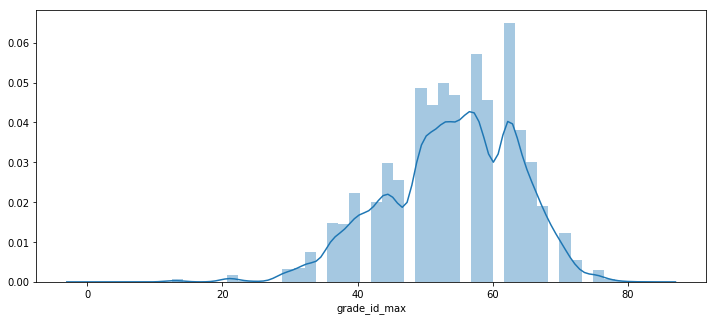

In [155]:
# Plot maximum climbing grade by climber
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
sns.distplot(by_person.grade_id_max)

Looks fairly normal! The most frequent highest grade seems to be 8a (hence the website name!), which is actually a pretty crazy grade. It also shows the selection bias of the underlying sample, as those who are actually logging their climbs on this website are inherently experienced climbers.

Let's look at the relationship between maximum grade and our physical features:

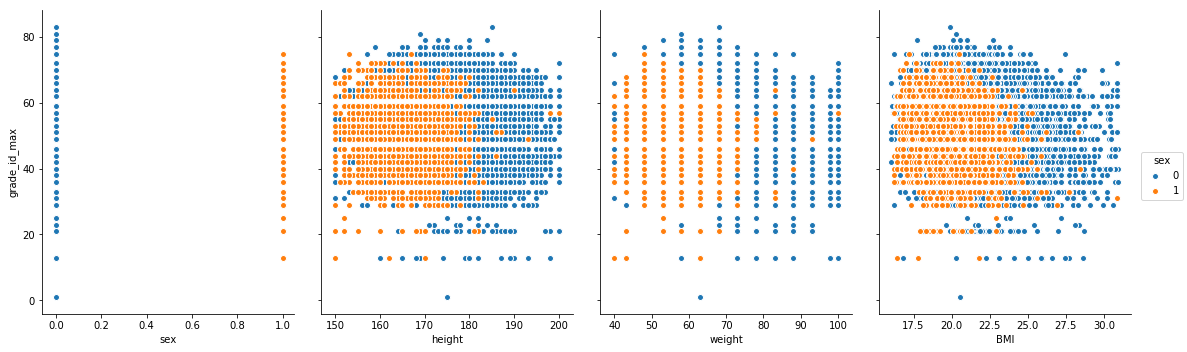

In [186]:
# Scatter plot for relationship between max grade and physical features

by_person_phy = by_person[["sex", "height", "weight", "BMI", "grade_id_max"]][by_person.physicals_invalid==0]
sns.pairplot(data= by_person_phy, hue="sex", x_vars=["sex","height","weight", "BMI"], y_vars=["grade_id_max"], size=5, aspect=.8)

Looks like there's essentially no meaningful relationship between physical traits and maximum grade. Climbers of either sex and at all levels of height, weight, and BMI combinations are seen climbing at all grades in fairly similar numbers.

This is both great and bad news. Great news in the sense that it shows that anyone, regardless of gender or physical composition, can send (climbing lingo for "complete a route") at the highest grades! Bad news in the sense that they will make pretty weak features in any sort of predictive model....

Let's do it anyway! We'll only include sex and BMI, as BMI provides a useful interaction between height and weight (and would likely lead to multicolinearity issues)

In [134]:
from sklearn import datasets
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cross_validation import KFold

In [219]:
# Get features and y of interest
features = ["sex", "BMI"]
X = by_person_phy[features]
y = by_person_phy["grade_id_max"]

# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# fit simple linear regressionmodel to the data
lr = LinearRegression()
lr.fit(X_train, y_train)

# Show R2 and MSE
r2 = cross_val_score(lr, X_test, y=y_test, cv=5, scoring="r2")
mse = cross_val_score(lr, X_test, y=y_test, cv=5, scoring="neg_mean_squared_error")
mse = np.sqrt(mse * -1)
print("R2", "MSE")
list(zip(r2,mse))

('R2', 'MSE')


[(0.013406168301722921, 9.3454024919118694),
 (0.074868961636495257, 8.9796883133771992),
 (0.072153941559218948, 9.2855302290754),
 (0.056649040247338966, 9.3553527846581765),
 (0.070434285793411155, 9.158552922799073)]

Yeah, these models aren't looking great. Let's look at correlations and see what has more predictive value:

In [136]:
# Correlations between max grade and all features

corr = by_person[by_person.miss_bd==0].corr()
corr.grade_id_max.sort_values(ascending=False)

grade_id_max         1.000000
grade_id_mean        0.864434
years_climbing       0.473426
years_to_max         0.411705
counter_sum          0.403902
redpoint_pct         0.333965
route_pct            0.108208
year_max_grade       0.072163
physicals_invalid    0.024257
BMI                 -0.009016
sex                 -0.018412
height              -0.023484
weight              -0.060186
flash_pct           -0.104553
onsite_pct          -0.128343
started             -0.295927
toprope_pct         -0.341944
miss_bd                   NaN
Name: grade_id_max, dtype: float64

Looks like some of the most correlated features to max grade are mean climbing grade (grade_id_mean), number of years of climbing experience (years_climbing), total number of climbs logged (counter_sum), number of years to get to one's max grade (years_to_max), and the percentage of total climbs that were redpointed (redpoint_pct). 

All of these features are most closely related to the amount of experience/number of climbs a climber has. This is....not too surprising, and a straightforward linear relationship (more experience = more likely to climb a higher grade).

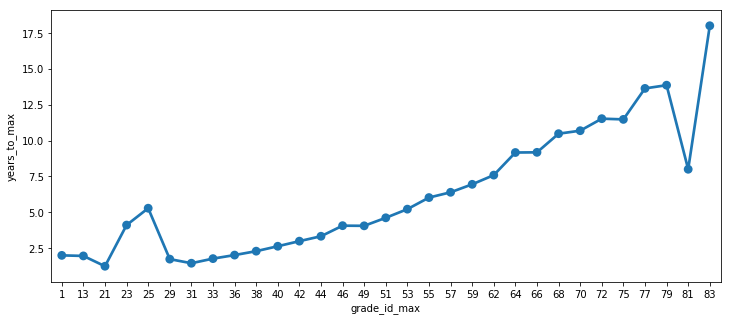

In [175]:
# Plot the average number of years it takes to get to each grade

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
time_to_max = by_person[["years_to_max", "grade_id_max"]].groupby("grade_id_max", as_index=False).mean()
sns.pointplot(x=time_to_max.grade_id_max, y=time_to_max.years_to_max)

We can see from the above graph plotting the average number of years it takes to reach each grade that there's an almost scarily linear relationship between years of experience and max grade (the weird blips at the beginning and end are due to a relative lack of data for these grades). By this, it makes sense for us to use a linear regression model for predictive purposes.

### Model building:

In [282]:
# Get iteration of the dataset where everyone has a birthday, so time-related features can be used
by_person_new = by_person[by_person.miss_bd==0]

from sklearn.model_selection import train_test_split
training_data,holdout = train_test_split(by_person_new,shuffle=True,test_size=0.10,random_state=123)

#Get features and y of interest
features = ["grade_id_mean", "years_climbing", "counter_sum", "years_to_max", "redpoint_pct"]
X = training_data[features]
y = training_data["grade_id_max"]

# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# fit simple linear regressionmodel to the data
lr = LinearRegression()
lr.fit(X_train, y_train)

# Show R2 and MSE
r2 = cross_val_score(lr, X_test, y=y_test, cv=5, scoring="r2")
mse = cross_val_score(lr, X_test, y=y_test, cv=5, scoring="neg_mean_squared_error")

print("R2", "MSE")
mse = np.sqrt(mse * -1)
list(zip(r2,mse))

('R2', 'MSE')


[(0.82683983054276466, 4.1361480030213427),
 (0.82935341739422519, 4.0792094647269517),
 (0.8269711544504279, 4.0312733135170387),
 (0.82969221530948323, 4.0796070390828518),
 (0.80971512139026025, 4.1407820803345041)]

In [283]:
# Print Coefficients
list(zip(features,lr.coef_))

[('grade_id_mean', 0.94643026957970511),
 ('years_climbing', 0.17107993085852966),
 ('counter_sum', 0.0085263860228661781),
 ('years_to_max', -0.078398000199034562),
 ('redpoint_pct', -1.8190974257955632)]

Our metrics are looking alright, with an RMSE of ~4 grades. Let's see if a Lasso will push out any coefficients.

In [284]:
# Fit Lasso
lr = Lasso(alpha=.5)
lr.fit(X_train, y_train)

list(zip(features,lr.coef_))

[('grade_id_mean', 0.90999895851513002),
 ('years_climbing', 0.10274514762051552),
 ('counter_sum', 0.0090774035210398011),
 ('years_to_max', 0.0),
 ('redpoint_pct', -0.0)]

It looks like the strongest variables are mean climbing grade (this makes sense) as well as number of years climbing. 

Redpoint_pct and years_to_max get pushed out with a relatively low alpha on our Lasso. Let's take these out and check out our model.

In [288]:
#Get features and y of interest
features = ["grade_id_mean", "years_climbing", "counter_sum"]
X = training_data[features]
y = training_data["grade_id_max"]

# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# fit simple linear regressionmodel to the data
lr = LinearRegression()
lr.fit(X_train, y_train)

# Show R2 and MSE
r2 = cross_val_score(lr, X_test, y=y_test, cv=5, scoring="r2")
mse = cross_val_score(lr, X_test, y=y_test, cv=5, scoring="neg_mean_squared_error")

print("R2", "MSE")
mse = np.sqrt(mse * -1)
list(zip(r2,mse))

('R2', 'MSE')


[(0.82699823776931813, 4.1342556924283329),
 (0.82837240883917351, 4.0909178872473539),
 (0.82604051877343021, 4.0420998774920447),
 (0.82788978811379688, 4.1011381793131463),
 (0.80741070626413702, 4.1657797708483342)]

These perform slighly worse than the earlier regresions, but there really isn't much change between the iterations above. This is likely because almost all regressors are derived from number of years/number of times someone has climbed (i.e., general climbing experience). Let's test against the holdout:

In [289]:
features = ["grade_id_mean", "years_climbing", "counter_sum", "years_to_max", "redpoint_pct"]

X_train = training_data[features]
y_train = training_data["grade_id_max"]

x_holdout = holdout[features]
y_holdout = holdout["grade_id_max"]


#Instantiate and train linear model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Create predictions using holdout set (x_holdout)
holdout_preds = lr.predict(x_holdout)

#Scores
RMSE_score = np.sqrt(mean_squared_error(y_holdout, holdout_preds))
R2_score = r2_score(y_holdout, holdout_preds)
                     
                     
#Print Scores
print "RMSE:", np.mean(RMSE_score)
print "R2:", np.mean(R2_score)

RMSE: 4.08253671512
R2: 0.821262968085


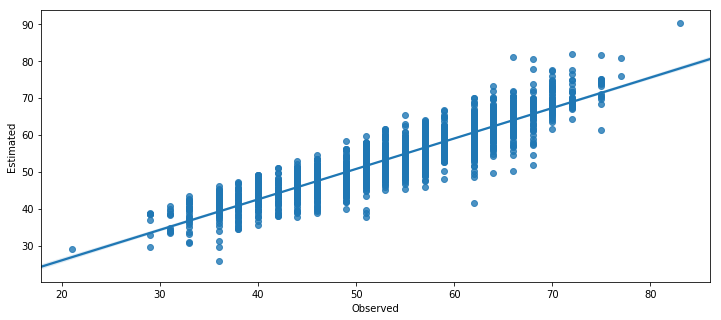

In [292]:
#Regplot predictions vs observed  
fig, ax = plt.subplots()
fig.set_size_inches(12, 5)
plot = sns.regplot(y_holdout, holdout_preds)
plot.set_xlabel("Observed")
plot.set_ylabel("Estimated")

This is pretty much a visual example of why we square mean squared errors. It looks like the residuals are pretty evenly distributed, with our predictions skewing on the higher side when it comes to higher grades.

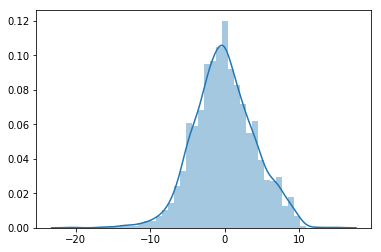

In [291]:
#Residual distribution
residuals = [est - obs for est, obs in zip(holdout_preds, y_holdout)]
sns.distplot(residuals)

# Conclusions and Future Work

It's sort of a no-brainer that increased climbing experience will have a somewhat linear relationship with one's maximum climbing grade, and it's unfortunate that physical features carry much weight to allow for a potentially more interesting model. Still, it was interesting to verify with analytics that nothing physical should hold climbers back from reaching higher grades. I found this project was mostly a good exercise in data validation/cleaning/building, as much of the user-input information wasn't usable on first pass.

Future work would include potentially making this a classification problem, classifying grades as either easy, medium, or hard, and checking the predictive properties. Again, this may not be too interesting because of the data available (as well as the subjectivity of these classifications), but would allow for more complex predictive models. It would also be interesting to step away from prediction and move toward creating a sort of route recommendation engine, where the model would suggest climbs based on geography and profiles of similar climbers.